# PRÁCTICA 3


***Competición en Kaggle***

---


**José María Sanchez Guerrero**


---




In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

# Utiles para seleccion de modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve

# Pipelines
from sklearn.pipeline import make_pipeline

# Grid Search
from sklearn.model_selection import GridSearchCV

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Lectura de datos con pandas
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

y_train = df_train['Precio_cat']
df_train = df_train.drop(['Precio_cat'], axis=1)

df_train = df_train.drop(['id'], axis=1)
sample = df_test['id'].to_frame()
df_test = df_test.drop(['id'], axis=1)

df = df_train.append(df_test, ignore_index=True) #4819 - end

## Preprocesado

In [3]:
# Quitamos las unidades de los valores en train
X = df.copy()

X['Nombre'] = X['Nombre'].str.split(' ').str[0]
X['Consumo'] = X.Consumo.str.extract(r'(\d+[.\d]*)').astype(float)
X['Motor_CC'] = X.Motor_CC.str.extract(r'(\d+[.\d]*)').astype(float)
X['Potencia'] = X.Potencia.str.extract(r'(\d+[.\d]*)').astype(float)


X.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
0,Maruti,G,2012.0,83000.0,Diesel,Manual,First,23.40,1248.0,74.00,5.0,NaN
1,Maruti,I,2016.0,4800.0,Petrol,Manual,First,20.51,998.0,67.04,5.0,NaN
2,Mahindra,F,2016.0,26000.0,Diesel,Manual,First,25.32,1198.0,77.00,6.0,NaN
3,Hyundai,E,2013.0,56127.0,Petrol,Manual,First,18.50,1197.0,80.00,5.0,NaN
4,Honda,H,2017.0,41981.0,Petrol,Manual,First,18.70,1199.0,88.70,5.0,NaN


In [4]:
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(
            col_name=col_name, unique_cat=unique_cat))

Feature 'Nombre' has 32 unique categories
Feature 'Ciudad' has 12 unique categories
Feature 'Combustible' has 6 unique categories
Feature 'Tipo_marchas' has 3 unique categories
Feature 'Mano' has 5 unique categories


In [5]:
#X = X.drop(['Nombre'], axis=1)

X.head(10)

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
0,Maruti,G,2012.0,83000.0,Diesel,Manual,First,23.40,1248.0,74.00,5.0,NaN
1,Maruti,I,2016.0,4800.0,Petrol,Manual,First,20.51,998.0,67.04,5.0,NaN
2,Mahindra,F,2016.0,26000.0,Diesel,Manual,First,25.32,1198.0,77.00,6.0,NaN
3,Hyundai,E,2013.0,56127.0,Petrol,Manual,First,18.50,1197.0,80.00,5.0,NaN
4,Honda,H,2017.0,41981.0,Petrol,Manual,First,18.70,1199.0,88.70,5.0,NaN
5,Maruti,C,2009.0,140000.0,Diesel,Manual,Second,17.80,1248.0,75.00,5.0,NaN
6,Maruti,G,2014.0,75074.0,Diesel,Manual,First,23.40,1248.0,74.00,5.0,NaN
7,Honda,J,2011.0,60000.0,Petrol,Automatic,First,16.80,1497.0,118.00,5.0,NaN
8,Hyundai,E,2017.0,26185.0,Petrol,Manual,First,18.60,1197.0,81.83,5.0,NaN
9,Maruti,L,2017.0,49224.0,Diesel,Manual,First,25.20,1248.0,74.00,5.0,NaN


In [6]:
print(X['Combustible'].value_counts().sort_values(ascending=False).head())

Diesel      3155
Petrol      2685
CNG           55
LPG           10
Electric       1
Name: Combustible, dtype: int64


In [7]:
X['Combustible'] = ['Other' if not (x == 'Diesel' or x == 'Petrol' or pd.isna(x)) else x for x in X['Combustible']]

In [8]:
todummy_list = ['Nombre', 'Ciudad', 'Combustible', 'Tipo_marchas', 'Mano']

# Funcion para las variables categoricas
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [9]:
X = dummy_df(X, todummy_list)

In [10]:
X.head(10)

,Año,Kilometros,Consumo,Motor_CC,Potencia,Asientos,Descuento,Nombre_Ambassador,Nombre_Audi,Nombre_BMW,...,Ciudad_L,Combustible_Diesel,Combustible_Other,Combustible_Petrol,Tipo_marchas_Automatic,Tipo_marchas_Manual,Mano_First,Mano_Fourth & Above,Mano_Second,Mano_Third
0,2012.0,83000.0,23.40,1248.0,74.00,5.0,NaN,0,0,0,...,0,1,0,0,0,1,1,0,0,0
1,2016.0,4800.0,20.51,998.0,67.04,5.0,NaN,0,0,0,...,0,0,0,1,0,1,1,0,0,0
2,2016.0,26000.0,25.32,1198.0,77.00,6.0,NaN,0,0,0,...,0,1,0,0,0,1,1,0,0,0
3,2013.0,56127.0,18.50,1197.0,80.00,5.0,NaN,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,2017.0,41981.0,18.70,1199.0,88.70,5.0,NaN,0,0,0,...,0,0,0,1,0,1,1,0,0,0
5,2009.0,140000.0,17.80,1248.0,75.00,5.0,NaN,0,0,0,...,0,1,0,0,0,1,0,0,1,0
6,2014.0,75074.0,23.40,1248.0,74.00,5.0,NaN,0,0,0,...,0,1,0,0,0,1,1,0,0,0
7,2011.0,60000.0,16.80,1497.0,118.00,5.0,NaN,0,0,0,...,0,0,0,1,1,0,1,0,0,0
8,2017.0,26185.0,18.60,1197.0,81.83,5.0,NaN,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9,2017.0,49224.0,25.20,1248.0,74.00,5.0,NaN,0,0,0,...,1,1,0,0,0,1,1,0,0,0


### Missing data

In [11]:
X.isnull().sum().sort_values(ascending=False).head(10)

Descuento             5164
Potencia               175
Asientos               106
Motor_CC               101
Consumo                 73
Año                     72
Kilometros              72
Nombre_Lamborghini       0
Nombre_Isuzu             0
Nombre_Jaguar            0
dtype: int64

In [12]:
X['Descuento'] = X['Descuento'].fillna(0)

tofill_list = ['Año', 'Kilometros', 'Consumo', 'Motor_CC', 'Asientos', 'Potencia']

for col_name in tofill_list:
    X[col_name].fillna(X[col_name].median(), inplace=True)

In [13]:
X.isnull().sum().sort_values(ascending=False).head()

Mano_Third              0
Nombre_Force            0
Nombre_Mercedes-Benz    0
Nombre_Maruti           0
Nombre_Mahindra         0
dtype: int64

### Outliers

In [14]:
from sklearn.preprocessing import scale

def find_outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.75*iqr
    ceiling = q3 + 1.75*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [15]:
out_index, out_values = find_outliers(X['Consumo'])
np.sort(out_values)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , 31.79,
       31.79, 32.26, 32.26, 33.44, 33.44, 33.44, 33.44, 33.54, 33.54,
       33.54, 33.54, 33.54])

In [16]:
X['Consumo'].replace(0, X['Consumo'].median(), inplace=True)

X['Kilometros'].values[X['Kilometros'] > 500000] = X['Kilometros'].median()

### Feature interaction

In [17]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Nombres de los atributos
    combos = list(combinations(list(df.columns), 2))
    col_names = list(df.columns) + ['_'.join(x) for x in combos]

    # Encontrar iteracciones
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    
    df = pd.DataFrame(df)
    df.columns = col_names

    # Eliminar las que dan 0
    noint_indices = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indices], axis=1)

    return df

In [18]:
X = add_interactions(X)
X.head(10)

,Año,Kilometros,Consumo,Motor_CC,Potencia,Asientos,Descuento,Nombre_Ambassador,Nombre_Audi,Nombre_BMW,...,Combustible_Petrol_Mano_Second,Combustible_Petrol_Mano_Third,Tipo_marchas_Automatic_Mano_First,Tipo_marchas_Automatic_Mano_Fourth & Above,Tipo_marchas_Automatic_Mano_Second,Tipo_marchas_Automatic_Mano_Third,Tipo_marchas_Manual_Mano_First,Tipo_marchas_Manual_Mano_Fourth & Above,Tipo_marchas_Manual_Mano_Second,Tipo_marchas_Manual_Mano_Third
0,2012.0,83000.0,23.40,1248.0,74.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2016.0,4800.0,20.51,998.0,67.04,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2016.0,26000.0,25.32,1198.0,77.00,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013.0,56127.0,18.50,1197.0,80.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2017.0,41981.0,18.70,1199.0,88.70,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,2009.0,140000.0,17.80,1248.0,75.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2014.0,75074.0,23.40,1248.0,74.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,2011.0,60000.0,16.80,1497.0,118.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2017.0,26185.0,18.60,1197.0,81.83,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,2017.0,49224.0,25.20,1248.0,74.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Dimension reduction PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pd.DataFrame(pca.fit_transform(X))

X_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,3.958513e+07,3.426526e+07,576094.201960,2.255920e+05,-40039.788719,295810.544726,8590.538751,-4255.864905,-20493.660897,-11898.542860
1,-1.385106e+08,-1.890526e+07,986134.413957,-1.107737e+06,9615.829650,5810.286523,44855.481051,4844.452911,5898.859918,-8790.380052
2,-9.048288e+07,-4.156017e+06,717478.026755,-4.818150e+05,-24828.282766,133831.748601,3729.125884,-29428.703786,-210.180692,-9289.269019
3,-2.340974e+07,1.761944e+07,207607.907665,-1.651528e+05,-66835.340171,-94267.265397,17319.773191,4603.186480,-22059.698595,24767.385260
4,-5.474592e+07,7.428036e+06,50889.039124,-3.513602e+05,-65408.647908,-62744.332991,17111.713063,805.496390,-14140.687603,22250.313919


## Train-test split and feature selection

In [20]:
import sklearn.feature_selection

x_train = X[:4819]
x_test = X[4819:]

select = sklearn.feature_selection.SelectKBest(k=40)
selected_features = select.fit(x_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

x_train_selected = x_train[colnames_selected]
x_test_selected = x_test[colnames_selected]

In [21]:
colnames_selected

['Año',
 'Motor_CC',
 'Potencia',
 'Combustible_Diesel',
 'Combustible_Petrol',
 'Tipo_marchas_Automatic',
 'Tipo_marchas_Manual',
 'Año_Motor_CC',
 'Año_Potencia',
 'Año_Combustible_Diesel',
 'Año_Combustible_Petrol',
 'Año_Tipo_marchas_Automatic',
 'Año_Tipo_marchas_Manual',
 'Kilometros_Combustible_Petrol',
 'Kilometros_Tipo_marchas_Automatic',
 'Kilometros_Tipo_marchas_Manual',
 'Consumo_Motor_CC',
 'Consumo_Potencia',
 'Consumo_Combustible_Petrol',
 'Consumo_Tipo_marchas_Automatic',
 'Consumo_Tipo_marchas_Manual',
 'Motor_CC_Potencia',
 'Motor_CC_Asientos',
 'Motor_CC_Combustible_Diesel',
 'Motor_CC_Tipo_marchas_Automatic',
 'Motor_CC_Tipo_marchas_Manual',
 'Motor_CC_Mano_First',
 'Potencia_Asientos',
 'Potencia_Combustible_Diesel',
 'Potencia_Tipo_marchas_Automatic',
 'Potencia_Tipo_marchas_Manual',
 'Potencia_Mano_First',
 'Asientos_Combustible_Diesel',
 'Asientos_Combustible_Petrol',
 'Asientos_Tipo_marchas_Automatic',
 'Asientos_Tipo_marchas_Manual',
 'Combustible_Diesel_Tipo_

# Pruebas

## RandomForest -- StackingClassifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished
0.8171809223424379
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
              precision    recall  f1-score   support

           1       0.83      0.69      0.75       269
           2       0.68      0.60      0.64       602
           3       0.83      0.91      0.87      2211
           4       0.81      0.75      0.78       978
           5       0.92      0.91      0.92       759

    accuracy                           0.82      4819
   macro avg       0.81      0.77      0.79      4819
weighted avg       0.82      0.82      0.

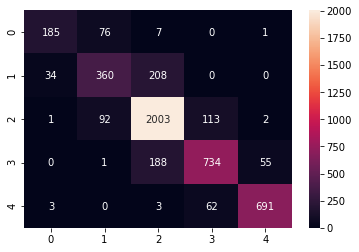

In [22]:
import seaborn as sns
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

rf = RandomForestClassifier()

# Creacion del grid de parametros
param_grid = {
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [100, 150, 175, 200]
}

# Entrenamos el modelo con las distintas opciones
gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
gs = gs.fit(x_train, y_train)

# Imprimimos los mejores resultados
print(gs.best_score_)
print(gs.best_params_)

# Creamos el modelos con los parametros elegidos
bp = gs.best_params_
RndForestClf = RandomForestClassifier(criterion=bp['criterion'],
                                    min_samples_leaf=bp['min_samples_leaf'],
                                    min_samples_split=bp['min_samples_split'],
                                    max_depth=bp['max_depth'],
                                    n_estimators=bp['n_estimators'])

estimators = [
    ('lr', LogisticRegression()),
    ('RndForestClf', RndForestClf),
    ('svr', make_pipeline(StandardScaler(), LinearSVC()) ),
    ('bayes', GaussianNB())
    ]
StackingClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

StackingClf.fit(x_train, y_train)

# Calculo de las predicciones mediante validacion cruzada (5-folds)
y_pred = cross_val_predict(StackingClf, x_train, y_train, cv=5)

print(classification_report(y_train, y_pred))
print("SCORE: ", accuracy_score(y_train, y_pred))

# Matriz de confusion de los resultados
confusion_matrix = confusion_matrix(y_train, y_pred)


sns.heatmap(confusion_matrix, annot = True, fmt='g')

In [23]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('svr', make_pipeline(MinMaxScaler(),
                          LinearSVC()
                          )
    )]
modelo = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000, tol=1e-5))

# Train the model
modelo.fit(x_train, y_train)

# Test on unseen data
labels = modelo.predict(x_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [80, 90, 100, None],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [50, 75, 100, 125, 150]
}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
gs = gs.fit(x_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

bp = gs.best_params_
RndForestClf = RandomForestClassifier(criterion=bp['criterion'],
                                    min_samples_leaf=bp['min_samples_leaf'],
                                    min_samples_split=bp['min_samples_split'],
                                    max_depth=bp['max_depth'],
                                    n_estimators=bp['n_estimators'])
RndForestClf.fit(x_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 22.2min finished
0.8196718415394493
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
# Test on unseen data
labels = StackingClf.predict(x_test)

sample["Precio_cat"] = np.round(labels).astype('int')

#sample.to_csv('16-STv3.csv', index=False)